In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
!pip install keras-metrics
!pip install scikit-plot
!pip install scipy
import pandas as pd
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from IPython.display import display
import keras_metrics
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
#import scikitplot as skplt
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import json

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
total_data = pd.read_csv("/content/drive/My Drive/cs224n project self/facts_opinions.csv")
total_data.head()

,Text,Label
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [4]:
def preproc(data):
  stopword=""
  cleantext = " "
  stopword = set(stopwords.words('english'))
  for i in word_tokenize(data):
    if(any(j.isdigit() for j in i)):
      continue
    i=i.lower()
    if (i not in stopword) and (len(i)>2):
      pattern1 = '[!.?$/\}#=<>"\*:,|_~;()^\']'
      pattern2 = '[\n\n]+'
      pattern3 = '[\ \ ]+'
      wout_sc = re.sub(pattern1,'',i)
      wout_el = re.sub(pattern2,'\n',wout_sc)
      wout_mspaces = re.sub(pattern3,' ',wout_el)
      cleaned_text = wout_mspaces.strip()
      cleaned_text=lemmatizer.lemmatize(cleaned_text)
      if (i not in stopword) and (len(i)>2):
        cleantext = cleantext+cleaned_text+" "
  return cleantext.strip()

In [5]:
for i in tqdm(range(len(total_data)),leave=True,position=0):
  total_data.iloc[i,0] = preproc(total_data.iloc[i,0])

100%|██████████| 94379/94379 [03:47<00:00, 415.39it/s] 


In [6]:
pickle_file_path = "/content/drive/My Drive/cs224n project self/facts_opinions.pkl"
total_data.to_pickle(pickle_file_path)

In [7]:
total_data.head()

,Text,Label
0,one reviewer mentioned watching episode ll hoo...,0
1,wonderful little production filming technique ...,0
2,thought wonderful way spend time hot summer we...,0
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,0


In [8]:
data_y = pd.DataFrame(data=total_data['Label'],columns=['Label'])
data_x = total_data.drop(columns="Label")

In [9]:
x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,train_size=0.9,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,train_size=0.9,random_state=42)

In [10]:
x_test.to_csv("/content/drive/My Drive/cs224n project self/x_test.csv",index=False)
y_test.to_csv("/content/drive/My Drive/cs224n project self/y_test.csv",index=False)

In [11]:
max_len=0
l=[]
index=[]
for i in range(len(x_train)):
  cur_len = len(x_train.iloc[i,0].split())
  if(cur_len>max_len):
    max_len=cur_len
print("Maximum length of sentence::",max_len)

Maximum length of sentence:: 1393


In [12]:
vocab={}
for i in tqdm(x_train['Text'],position=0,leave=True):
  for j in i.split():
    if j not in vocab:
      vocab[j]=1
    else:
      vocab[j]+=1
vocab = sorted(vocab, key=vocab.get, reverse=True)

100%|██████████| 76446/76446 [00:02<00:00, 37950.76it/s]


In [13]:
def vectorize(data,vocab):
  print("\nGenerating Vectors......")
  max_seq_len=1400
  row=0
  ## converting sequence to vector...
  new_data = pd.DataFrame(columns=["Text"])
  for i in tqdm(data['Text'],position=0,leave=True):
    sent=[]
    for j in i.split():
      try:
        sent.append((vocab.index(j))+1)
      except:
        continue
    new_data.loc[row] = [sent]
    row+=1
  new_data = sequence.pad_sequences(new_data['Text'], maxlen=max_seq_len)
  return new_data

In [14]:
x_train_vec = vectorize(x_train,vocab)
x_cv_vec = vectorize(x_cv,vocab)
x_test_vec = vectorize(x_test,vocab)


Generating Vectors......


100%|██████████| 76446/76446 [16:14<00:00, 78.46it/s]



Generating Vectors......


100%|██████████| 8495/8495 [01:58<00:00, 71.51it/s]



Generating Vectors......


100%|██████████| 9438/9438 [02:10<00:00, 72.18it/s]


In [15]:
import json
# Basic LSTM model with 0.01 learn rate and 1000 batch size
lstm_model1 = Sequential()
lstm_model1.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model1.add(LSTM(20))
lstm_model1.add(Dense(2, activation='softmax'))
checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/model1-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values1=lstm_model1.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs224n project self/saved models/lstm_model1_history.json', 'w') as f:
    json.dump(values1.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - acc: 0.8928 - loss: 0.2970
Epoch 1: val_loss improved from inf to 0.04280, saving model to /content/drive/My Drive/cs224n project self/saved models/model1-001-0.955393-0.986816.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - acc: 0.8936 - loss: 0.2951 - val_acc: 0.9868 - val_loss: 0.0428
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - acc: 0.9925 - loss: 0.0287
Epoch 2: val_loss did not improve from 0.04280
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - acc: 0.9925 - loss: 0.0287 - val_acc: 0.9847 - val_loss: 0.0480
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - acc: 0.9973 - loss: 0.0117
Epoch 3: val_loss did not improve from 0.04280
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - acc: 0.9973 - loss: 0.0117 - val_acc: 0.9866 - val_loss: 0.0465


In [16]:
# Basic LSTM model with 0.1 learn rate and 1000 batch size
lstm_model2 = Sequential()
lstm_model2.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model2.add(LSTM(20))
lstm_model2.add(Dense(2, activation='softmax'))
checkpoint2 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/model2-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model2.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.1), metrics=['acc'])
values2=lstm_model2.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint2])
with open('/content/drive/My Drive/cs224n project self/saved models/lstm_model2_history.json', 'w') as f:
    json.dump(values2.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - acc: 0.9029 - loss: 0.2002
Epoch 1: val_loss improved from inf to 0.04899, saving model to /content/drive/My Drive/cs224n project self/saved models/model2-001-0.959017-0.983991.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - acc: 0.9036 - loss: 0.1990 - val_acc: 0.9840 - val_loss: 0.0490
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - acc: 0.9902 - loss: 0.0335
Epoch 2: val_loss did not improve from 0.04899
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - acc: 0.9902 - loss: 0.0335 - val_acc: 0.9827 - val_loss: 0.0547
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - acc: 0.9813 - loss: 0.0583
Epoch 3: val_loss did not improve from 0.04899
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - acc: 0.9811 - loss: 0.0589 - val_acc: 0.9469 - val_loss: 0.1498


In [17]:
# Basic LSTM model with 1 learn rate and 1000 batch size
lstm_model3 = Sequential()
lstm_model3.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model3.add(LSTM(20))
lstm_model3.add(Dense(2, activation='softmax'))
checkpoint3 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/model3-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model3.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1.0), metrics=['acc'])
values3=lstm_model3.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint3])
with open('/content/drive/My Drive/cs224n project self/saved models/lstm_model3_history.json', 'w') as f:
    json.dump(values3.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - acc: 0.6313 - loss: 0.7631
Epoch 1: val_loss improved from inf to 0.56640, saving model to /content/drive/My Drive/cs224n project self/saved models/model3-001-0.671297-0.706062.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - acc: 0.6318 - loss: 0.7617 - val_acc: 0.7061 - val_loss: 0.5664
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - acc: 0.7099 - loss: 0.5675
Epoch 2: val_loss did not improve from 0.56640
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - acc: 0.7099 - loss: 0.5675 - val_acc: 0.7009 - val_loss: 0.5679
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - acc: 0.7092 - loss: 0.5654
Epoch 3: val_loss did not improve from 0.56640
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - acc: 0.7092 - loss: 0.5654 - val_acc: 0.7054 - val_loss: 0.5682


In [18]:
import json
with open('/content/drive/My Drive/cs224n project self/saved models/lstm_model3_history.json', 'w') as f:
    json.dump(values3.history, f)

In [19]:
# Basic LSTM model with 0.01 learn rate and 100 batch size
lstm_model4 = Sequential()
lstm_model4.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model4.add(LSTM(20))
lstm_model4.add(Dense(2, activation='softmax'))
checkpoint4 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/model4-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model4.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values4=lstm_model4.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=100,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint4])
with open('/content/drive/My Drive/cs224n project self/saved models/lstm_model4_history.json', 'w') as f:
    json.dump(values4.history, f)

Epoch 1/3
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.9589 - loss: 0.1182
Epoch 1: val_loss improved from inf to 0.04189, saving model to /content/drive/My Drive/cs224n project self/saved models/model4-001-0.978115-0.986816.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - acc: 0.9589 - loss: 0.1181 - val_acc: 0.9868 - val_loss: 0.0419
Epoch 2/3
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.9946 - loss: 0.0186
Epoch 2: val_loss did not improve from 0.04189
765/765 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - acc: 0.9946 - loss: 0.0186 - val_acc: 0.9841 - val_loss: 0.0562
Epoch 3/3
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.9977 - loss: 0.0090
Epoch 3: val_loss did not improve from 0.04189
765/765 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - acc: 0.9977 - loss: 0.0090 - val_acc: 0.9847 - val_loss: 0.0554


In [20]:
# Basic LSTM model with 0.01 learn rate and 10 batch size
lstm_model5 = Sequential()
lstm_model5.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model5.add(LSTM(20))
lstm_model5.add(Dense(2, activation='softmax'))
checkpoint5 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/model5-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model5.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values5=lstm_model5.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=10,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint5])
with open('/content/drive/My Drive/cs224n project self/saved models/lstm_model5_history.json', 'w') as f:
    json.dump(values5.history, f)

Epoch 1/3
7644/7645 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.9653 - loss: 0.0983
Epoch 1: val_loss improved from inf to 0.04505, saving model to /content/drive/My Drive/cs224n project self/saved models/model5-001-0.975918-0.986698.keras
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 315s 41ms/step - acc: 0.9653 - loss: 0.0983 - val_acc: 0.9867 - val_loss: 0.0450
Epoch 2/3
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.9909 - loss: 0.0305
Epoch 2: val_loss did not improve from 0.04505
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 313s 41ms/step - acc: 0.9909 - loss: 0.0305 - val_acc: 0.9767 - val_loss: 0.0786
Epoch 3/3
7644/7645 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.9875 - loss: 0.0408
Epoch 3: val_loss did not improve from 0.04505
7645/7645 ━━━━━━━━━━━━━━━━━━━━ 323s 41ms/step - acc: 0.9875 - loss: 0.0408 - val_acc: 0.9778 - val_loss: 0.0657


In [21]:
model_paths = ['/content/drive/My Drive/cs224n project self/saved models/model1-002-0.993766-0.987508.keras',
               '/content/drive/My Drive/cs224n project self/saved models/model2-001-0.961586-0.961187.keras',
               '/content/drive/My Drive/cs224n project self/saved models/model3-003-0.703124-0.684140.keras',
               '/content/drive/My Drive/cs224n project self/saved models/model4-002-0.988318-0.983939.keras',
               '/content/drive/My Drive/cs224n project self/saved models/model5-002-0.986675-0.980593.keras'
]

In [22]:
from tensorflow.keras.utils import to_categorical
# Placeholder for evaluation results
results = {}

# Loop through each model, load it, and evaluate on x_test_vec
for model_path in model_paths:
    # Load the model
    model = load_model(model_path)

    # Evaluate the model on the test data
    y_test_one_hot = to_categorical(y_test, num_classes=2)

# Now you can evaluate the model
    loss, accuracy = model.evaluate(x_test_vec, y_test_one_hot, verbose=0)
    #loss, accuracy = model.evaluate(x_test_vec, y_test, verbose=0)

    # Store the results
    results[model_path] = {"loss": loss, "accuracy": accuracy}

# Print evaluation results for each model
for model_path, result in results.items():
    print(f"Model: {model_path}")
    print(f"  Loss: {result['loss']:.4f}")
    print(f"  Accuracy: {result['accuracy']:.4f}")


Model: /content/drive/My Drive/cs224n project self/saved models/model1-002-0.993766-0.987508.keras
  Loss: 0.4852
  Accuracy: 0.8655
Model: /content/drive/My Drive/cs224n project self/saved models/model2-001-0.961586-0.961187.keras
  Loss: 0.8979
  Accuracy: 0.7498
Model: /content/drive/My Drive/cs224n project self/saved models/model3-003-0.703124-0.684140.keras
  Loss: 0.7131
  Accuracy: 0.5676
Model: /content/drive/My Drive/cs224n project self/saved models/model4-002-0.988318-0.983939.keras
  Loss: 0.4586
  Accuracy: 0.8769
Model: /content/drive/My Drive/cs224n project self/saved models/model5-002-0.986675-0.980593.keras
  Loss: 0.4161
  Accuracy: 0.8512


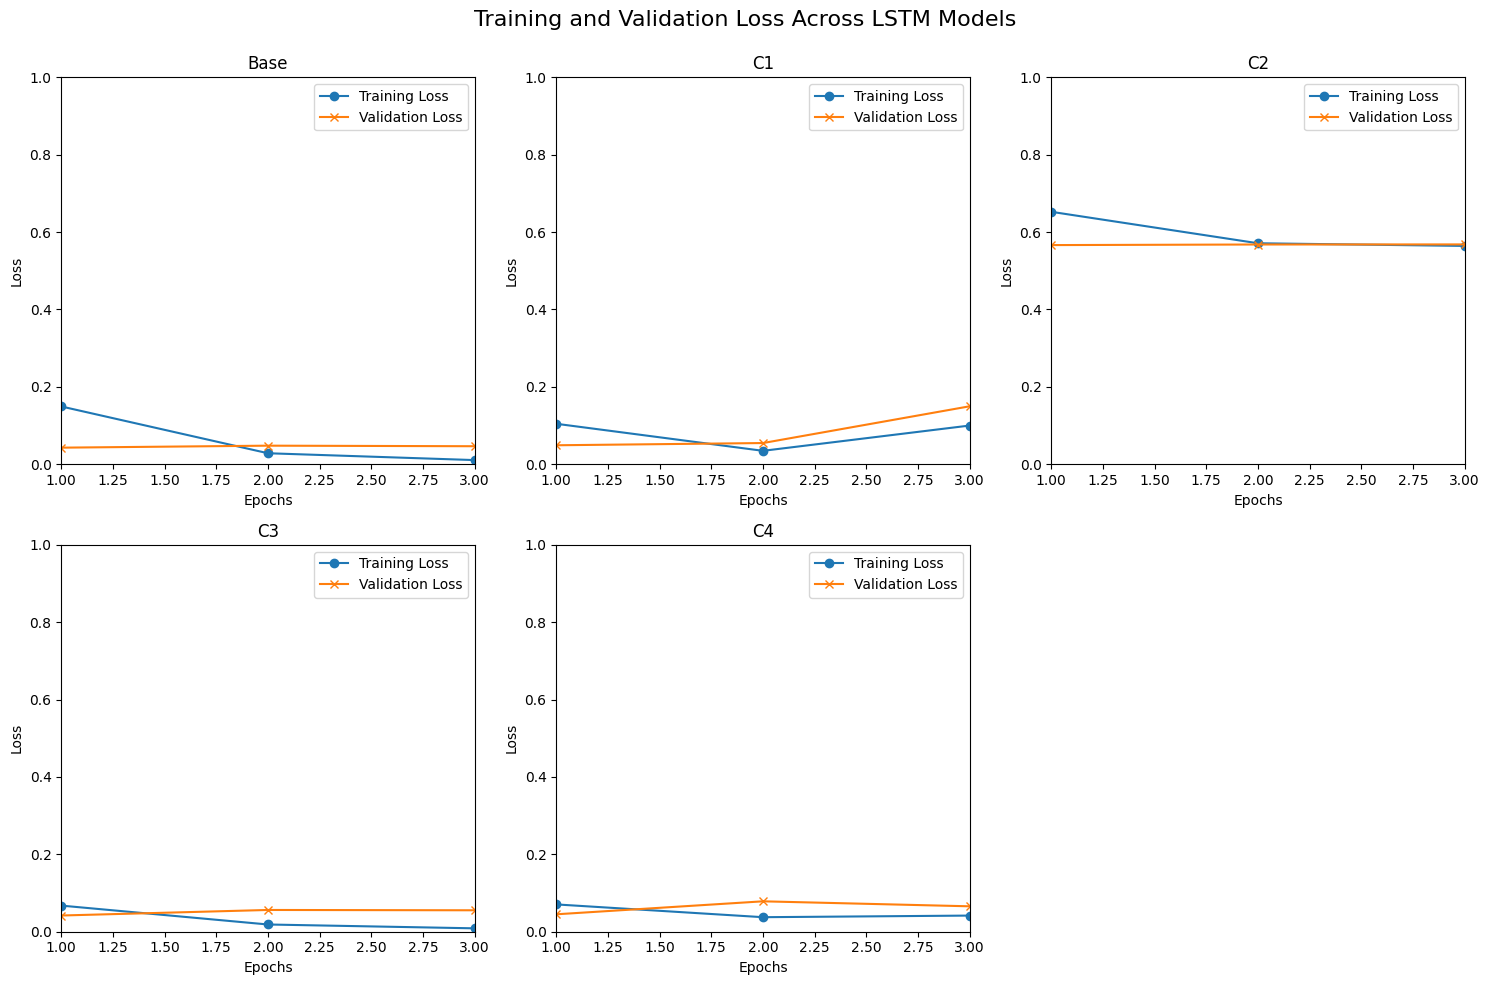

In [23]:
# File paths for the saved JSON histories
history_files = [
    '/content/drive/My Drive/cs224n project self/saved models/lstm_model1_history.json',
    '/content/drive/My Drive/cs224n project self/saved models/lstm_model2_history.json',
    '/content/drive/My Drive/cs224n project self/saved models/lstm_model3_history.json',
    '/content/drive/My Drive/cs224n project self/saved models/lstm_model4_history.json',
    '/content/drive/My Drive/cs224n project self/saved models/lstm_model5_history.json'
]

# Set up the figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes array for easy indexing (ignoring extra subplot space)
axes = axes.flatten()

# Loop through each model and plot the loss
for i, history_file in enumerate(history_files):
    # Load the history
    with open(history_file, 'r') as f:
        history = json.load(f)

    # Extract loss and validation loss
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Plot in the respective subplot
    ax = axes[i]
    ax.plot(epochs, loss, label='Training Loss', marker='o')
    ax.plot(epochs, val_loss, label='Validation Loss', marker='x')
    if i == 0:
      ax.set_title('Base')
    else:
      ax.set_title(f'C{i}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_xlim(1, 3)
    ax.set_ylim(0, 1)
    ax.legend()

# Remove unused subplot (if any)
for j in range(len(history_files), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Training and Validation Loss Across LSTM Models', fontsize=16)
plt.show()


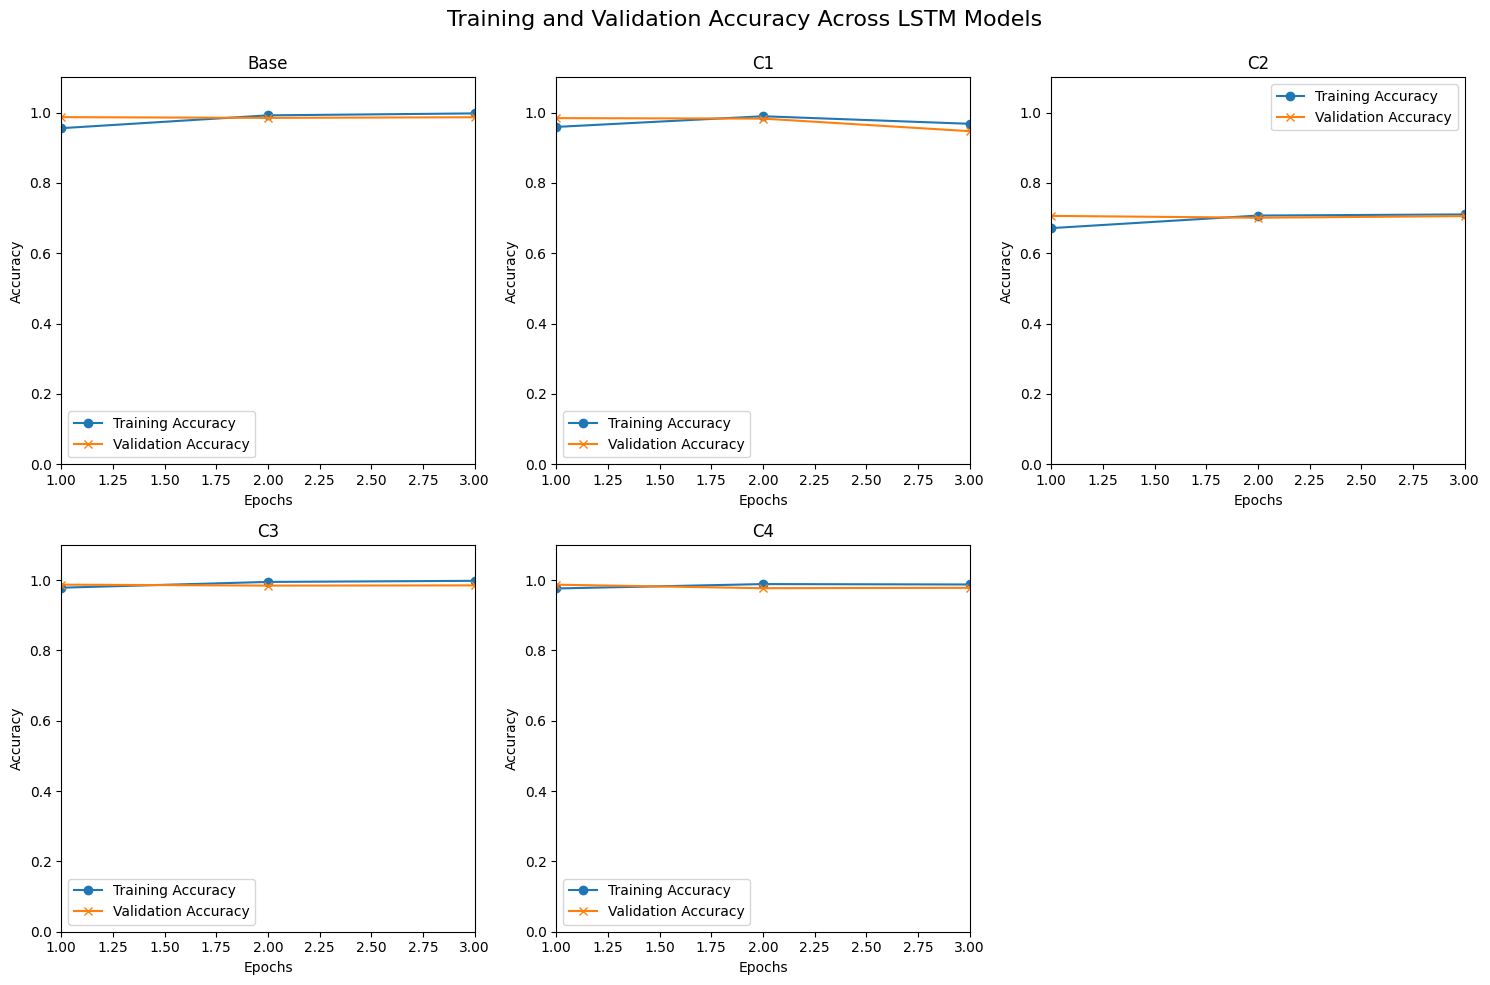

In [24]:
# Set up the figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes array for easy indexing (ignoring extra subplot space)
axes = axes.flatten()

# Loop through each model and plot the accuracy
for i, history_file in enumerate(history_files):
    # Load the history
    with open(history_file, 'r') as f:
        history = json.load(f)

    # Extract accuracy and validation accuracy
    acc = history['acc']
    val_acc = history['val_acc']
    epochs = range(1, len(acc) + 1)

    # Plot in the respective subplot
    ax = axes[i]
    ax.plot(epochs, acc, label='Training Accuracy', marker='o')
    ax.plot(epochs, val_acc, label='Validation Accuracy', marker='x')
    if i == 0:
      ax.set_title('Base')
    else:
      ax.set_title(f'C{i}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(1, 3)
    ax.set_ylim(0, 1.1)
    ax.legend()

# Remove unused subplot (if any)
for j in range(len(history_files), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Training and Validation Accuracy Across LSTM Models', fontsize=16)
plt.show()
